In [82]:
%reset
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [83]:
# solves G''(z) + (N^2(z) - omega^2)G(z)/c^2 = 0 
#   subject to G'(0) = gG(0)/c^2 (free surface) & G(-D) = 0 (flat bottom)
# G(z) is normalized so that the vertical integral of (G'(z))^2 is D
# G' is dimensionless, G has dimensions of length

# - N is buoyancy frequency [s^-1] (nX1 vector)
# - depth [m] (maximum depth is considered the sea floor) (nX1 vector)
# - omega is frequency [s^-1] (scalar)
# - mmax is the highest baroclinic mode calculated
# - m=0 is the barotropic mode
# - 0 < m <= mmax are the baroclinic modes
# - Modes are calculated by expressing in finite difference form 1) the
#  governing equation for interior depths (rows 2 through n-1) and 2) the
#  boundary conditions at the surface (1st row) and the bottome (last row).
# - Solution is found by solving the eigenvalue system A*x = lambda*B*x
def vertical_modes(N2_0, Depth, omega, mmax):
    z = -1 * Depth

    if np.size(np.shape(N2_0)) > 1:
        N2 = np.nanmean(N2_0, axis=1)
    else:
        N2 = N2_0

    n = np.size(z)
    nm1 = n - 1
    nm2 = n - 2
    gravity = 9.82
    # ----- vertical increments
    dz = np.concatenate([[0], z[1:] - z[0:nm1]])  # depth increment [m]
    dzm = np.concatenate([[0], 0.5 * (z[2:] - z[0:nm2]), [0]])  # depth increment between midpoints [m]
    # ----- sparse matrices
    # A = row pos, B = col pos, C = val  
    A = np.concatenate([[0], [0], np.arange(1, nm1), np.arange(1, nm1), np.arange(1, nm1), [n - 1]])
    B = np.concatenate([[0], [1], np.arange(1, nm1), np.arange(0, nm2), np.arange(2, n), [n - 1]])
    C = np.concatenate(
        [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
         -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
        # [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
        #  -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
    mat1 = coo_matrix((C, (A, B)), shape=(n, n))

    D = np.concatenate([[0], np.arange(1, n)])
    E = np.concatenate([[0], np.arange(1, n)])
    F = np.concatenate([[gravity], N2[1:] - omega * omega])  # originially says N2[1:,10]
    mat2 = coo_matrix((F, (D, E)), shape=(n, n))

    # compute eigenvalues and vectors 
    vals, vecs = eigs(mat1, k=mmax + 1, M=mat2, sigma=0)
    eigenvalue = np.real(vals)
    wmodes = np.real(vecs)
    s_ind = np.argsort(eigenvalue)
    eigenvalue = eigenvalue[s_ind]
    wmodes = wmodes[:, s_ind]
    m = np.size(eigenvalue)
    c = 1 / np.sqrt(eigenvalue)  # kelvin wave speed
    # normalize mode (shapes)
    Gz = np.zeros(np.shape(wmodes))
    G = np.zeros(np.shape(wmodes))
    for i in range(m):
        dw_dz = np.nan * np.ones(np.shape(z))
        dw_dz[0] = (wmodes[1, i] - wmodes[0, i]) / (z[1] - z[0])
        dw_dz[-1] = (wmodes[-1, i] - wmodes[-2, i]) / (z[-1] - z[-2])
        for j in range(1, len(z) - 1):
            dw_dz[j] = (wmodes[j + 1, i] - wmodes[j - 1, i]) / (z[j + 1] - z[j - 1])
        # dw_dz = np.gradient(wmodes[:, i], z)
        norm_constant = np.sqrt(np.trapz((dw_dz * dw_dz), (-1 * z)) / (-1 * z[-1]))
        # norm_constant = np.abs(np.trapz(dw_dz * dw_dz, z) / Depth.max())

        if dw_dz[0] < 0:
            norm_constant = -1 * norm_constant
        Gz[:, i] = dw_dz / norm_constant

        norm_constant_G = np.sqrt(np.trapz((wmodes[:, i] * wmodes[:, i]), (-1 * z)) / (-1 * z[-1]))
        G[:, i] = wmodes[:, i] / norm_constant

    #epsilon = np.nan * np.zeros((5, 5, 5))  # barotropic and first 5 baroclinic
    #for i in range(0, 5):  # i modes
    #    for j in range(0, 5):  # j modes
    #        for m in range(0, 5):  # k modes
    #            epsilon[i, j, m] = np.trapz((Gz[:, i] * Gz[:, j] * Gz[:, m]), -1.0*z) / (-1.0*z[-1])

    return G, Gz, c#, epsilon


Computing QG modes at an individual gridbox.

In [84]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
from matplotlib.pyplot import cm
import cmocean

In [85]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=20 #1/4 degree NeverWorld setup
#run=26 #1/8 degree NeverWorld setup
#run=28 #1/16 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400
sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [86]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']

xh = fs.xh.values
yh = fs.yh.values

taux= forcing.taux.values[0,:,:]; taux=(taux[:,1:]+taux[:,:-1])/2.
taux.shape

(560, 240)

In [87]:
#1/4 degree:560 lat x 240 lon 
#90, 400 is a problem
index_lon=60; index_lat=460

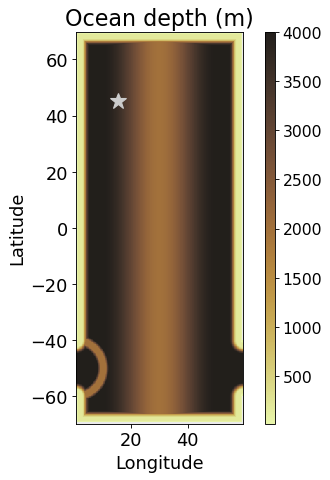

In [88]:
#Plotting ocean depth
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Ocean depth (m)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,depth,cmap=cmocean.cm.turbid)
ax1.plot(xh[index_lon],yh[index_lat],'*',markersize=15,color=[0.8, 0.8, 0.8])
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

In [143]:
Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(xh),1]);   Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)


v = (np.array(av['v'][-1,:,:,:])); v=(v[:,:-1,:]+v[:,1:,:])/2; v=v[:,index_lat,index_lon]
u = (np.array(av['u'][-1,:,:,:])); u=(u[:,:,:-1]+u[:,:,1:])/2; u=u[:,index_lat,index_lon]


h = np.array(av['h'][-1,:,index_lat,index_lon]);
eta = np.zeros(len(Layer)+1);

for i in range(1,len(Layer)+1):
    eta[i]=np.nansum(h[0:i])    
#To make sure eta is correct: #print(eta[:,50]); print(h[:,50])    
eta=(eta[1:]+eta[:-1])/2.
drhodz=drho/h
N2=(9.81/1025.)*drhodz


N2[N2>1.e-3] =np.nan

eta_filtered = eta[~np.isnan(N2)]
u_filtered = u[~np.isnan(N2)]
v_filtered = v[~np.isnan(N2)]
N2_filtered = N2[~np.isnan(N2)]

print(u_filtered.shape,N2_filtered.shape)

(12,) (12,)


In [144]:
Interface.shape

(16,)

In [145]:
print(N2)
print(N2_filtered)
print(eta)
print(eta_filtered)


[           nan            nan            nan 2.95994380e-05
 2.36744201e-05 2.00548904e-05 2.16152351e-05 2.01702435e-05
 1.75111203e-05 1.31584180e-05 9.41099818e-06 6.86284255e-06
 4.35880459e-06 2.61041041e-06 3.88181365e-06]
[2.95994380e-05 2.36744201e-05 2.00548904e-05 2.16152351e-05
 2.01702435e-05 1.75111203e-05 1.31584180e-05 9.41099818e-06
 6.86284255e-06 4.35880459e-06 2.61041041e-06 3.88181365e-06]
[4.35973816e-02 3.59747421e-01 1.88826236e+00 9.36798928e+01
 3.01452324e+02 5.55891785e+02 8.14858185e+02 1.05643253e+03
 1.29921729e+03 1.56584241e+03 1.88237878e+03 2.24701782e+03
 2.66383325e+03 3.14554102e+03 3.53779126e+03]
[  93.67989278  301.45232391  555.89178467  814.85818481 1056.43252563
 1299.21728516 1565.84240723 1882.37878418 2247.01782227 2663.83325195
 3145.54101562 3537.79125977]


In [146]:
eta_filtered

array([  93.67989278,  301.45232391,  555.89178467,  814.85818481,
       1056.43252563, 1299.21728516, 1565.84240723, 1882.37878418,
       2247.01782227, 2663.83325195, 3145.54101562, 3537.79125977])

In [148]:
#nmodes=len(N2_filtered)-3
nmodes=9
[G, Gz, c]=vertical_modes(N2_filtered, eta_filtered, 0, nmodes)

In [149]:
Gz.shape #z by number of modes

(12, 10)

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Depth')

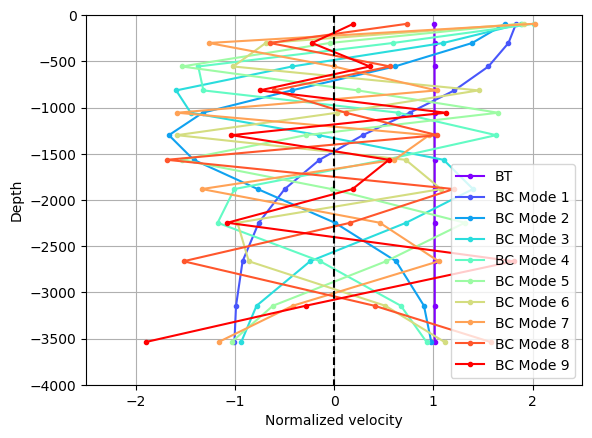

In [150]:
color=iter(cm.rainbow(np.linspace(0,1,nmodes+1))) #rainbow
plt.style.use('default')
for i in range(nmodes+1):
    print(i)
    c=next(color)
    plt.plot(Gz[:,i],-eta_filtered,'.-',c=c)
plt.grid()
plt.legend(['BT','BC Mode 1','BC Mode 2','BC Mode 3','BC Mode 4','BC Mode 5','BC Mode 6','BC Mode 7','BC Mode 8','BC Mode 9','BC Mode 10','BC Mode 11'])
plt.plot([0, 0],[0, -4000],'--',color=[0,0,0])
plt.xlim(-2.5, 2.5)
plt.ylim(-4000, 0);
plt.xlabel('Normalized velocity')
plt.ylabel('Depth')

Solving for the amplitude of each mode; i.e. represent the flow in terms of a linear combination of the modes we solved for above.

In [151]:
amp_u=np.linalg.lstsq(Gz,u_filtered)[0]
amp_u=np.tile(amp_u,[len(u_filtered),1]) #tiling this in depth... originally the dimensions are just the number of modes.

amp_v=np.linalg.lstsq(Gz,v_filtered)[0]
amp_v=np.tile(amp_v,[len(v_filtered),1])

In [152]:
amp_u.shape

(12, 10)

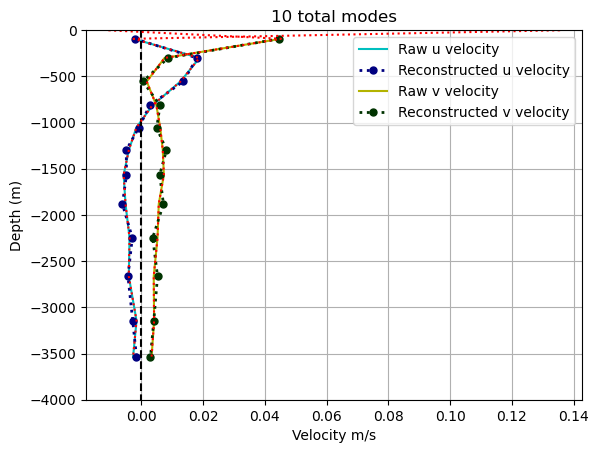

In [154]:
plt.style.use('default')


plt.plot(u_filtered,-eta_filtered,c='c')
plt.plot(np.nansum(Gz*amp_u,axis=1),-eta_filtered,'.:',c=[0., 0., 0.5],linewidth=2,markersize=10)

plt.plot(v_filtered,-eta_filtered,c=[0.7, 0.7, 0])
plt.plot(np.nansum(Gz*amp_v,axis=1),-eta_filtered,'.:',c=[0., 0.2, 0.],linewidth=2,markersize=10)

plt.grid()
plt.plot([0, 0],[0, -4000],'--',color=[0,0,0])

#plt.xlim(-.3, .3)
plt.ylim(-4000, 0);
plt.xlabel('Velocity m/s')
plt.legend(['Raw u velocity','Reconstructed u velocity','Raw v velocity','Reconstructed v velocity'])
plt.ylabel('Depth (m)')
plt.title('%i total modes' % (nmodes+1))
plt.plot(u,-eta,':r')
plt.plot(v,-eta,':r')
#plt.show()

In [142]:
print(amp_u[0,0],amp_v[0,0])

0.0014948074735069052 0.006485110963503066


([<matplotlib.axis.XTick at 0x2b97483030d0>,
 <a list of 10 Text major ticklabel objects>)

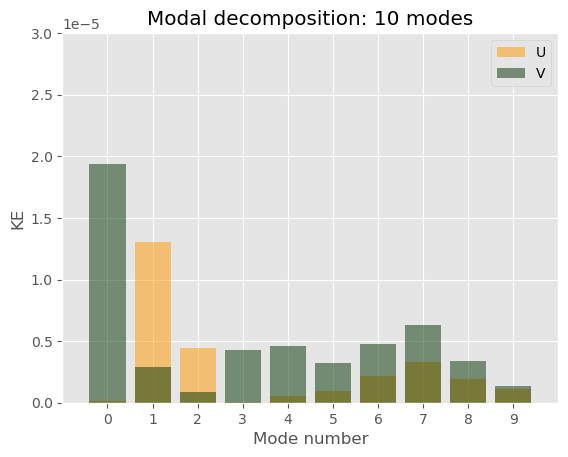

In [35]:
plt.style.use('ggplot')

x = np.linspace(0,nmodes,nmodes+1)
amp1 = amp_u[0,:]
amp2 = amp_v[0,:]

plt.bar(x, 0.5*amp1**2, color=[1., .6, 0.],alpha=0.5)
plt.bar(x, 0.5*amp2**2, color=[0., 0.2, 0.],alpha=0.5)
plt.xlabel("Mode number")
plt.ylabel("KE")
plt.title("Modal decomposition: %i modes" % (nmodes+1))
plt.legend(['U','V'])
plt.ylim(0,3e-5)
plt.xlim(-1,10)
plt.xticks((0,1,2,3,4,5,6,7,8,9))

In [18]:
amp_u.shape

(12, 10)

In [111]:
((10./1025.)*0.11/.01)

0.10731707317073172

In [129]:
a=np.linspace(1,nmodes+1,nmodes+1)
a

array([1., 2., 3., 4., 5., 6., 7., 8.])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])